In [1]:
import sys
sys.path.append('../run_analyses/')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from support.charting import primaryColors, fullColors, save_fig
from support.load import loadAllData, methodParams
from support.util import titles, order, methodTitle, modelTitle

from modelConfig import models
from util.util import getLeverNames


In [2]:
all_data = loadAllData()


 loading data for mordm

--------------------------------
Loading MOEA intertemporal
Loading archives from ../data/mordm/optimize/archives_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Pareto for intertemporal
Loading pareto from ../data/mordm/optimize/nondominated_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Robustness Summary intertemporal
Loading Robust Summary from ../data/mordm/robustness/summary_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
--------------------------------
Loading MOEA plannedadaptive
Loading archives from ../data/mordm/optimize/archives_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_plannedadaptive_NSGAIIHybrid_runs50_nfe100

In [3]:
from collections import defaultdict

pfs = ['intertemporal', 'plannedadaptive', 'dps']

alldata_by_pf = defaultdict(dict)

for pf in pfs:
    pfdata = defaultdict(dict)
    for method, data in all_data.items():

        methoddata = defaultdict(dict)
        for k, v in data.items():
            if not v: continue
                
            v = v[pf]
            
            if len(v) == 1:
                v = v[0]
                if k=='nondominated':
                    print(pf, method, len(v)) 
            elif k=='archives' or k=='nondominated':
                if k=='nondominated':
                    print(pf, method, [len(entry) for entry in v])
                # last item is same scenario as used in mordm
                v = pd.concat(v[0:4], ignore_index=True)
                
            methoddata[k] = v
        pfdata[method] = methoddata
    alldata_by_pf[pf] = pfdata
        

intertemporal mordm 90
intertemporal multi [34, 36, 71, 59, 91]
intertemporal moro 7
plannedadaptive mordm 48
plannedadaptive multi [28, 37, 5, 7, 36]
plannedadaptive moro 6
dps mordm 110
dps multi [60, 11, 8, 15, 115]
dps moro 22


In [7]:
from ema_workbench import Policy, Scenario, ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

def get_policies(archive, method):
    policies = []
    for i, row in archive.iterrows():
        policy = Policy(f'{method}_{i}', **row.to_dict())
        policies.append(policy)
    return policies

In [8]:
from methodConfig import MultiParams
from modelConfig import baseModelParams as base_scenario

all_scenarios = MultiParams(rootFolder='.').references

for k, v in all_scenarios.items():
    v.insert(0, base_scenario)

In [132]:
from ema_workbench.analysis import parcoords
import pareto
from deap.tools.indicator import hv

def plot_parcoords(all_outcomes, methods=['mordm', 'multi', 'moro']):
    for scenario in range(5):
        scenario = str(scenario)

        colors = iter(sns.color_palette())

        data = pd.concat(all_outcomes)
        data = data.iloc[:, 0:4]

        limits = parcoords.get_limits(data.iloc[:, 0:4])
        limits.iloc[0,:] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.invert_axis('max_P')

        for method, outcome in zip(methods, all_outcomes):

            color = next(colors)
            data = outcome.loc[outcome.scenario==scenario]
            data = data.iloc[:, 0:4]

            resorted = pareto.eps_sort([list(data.itertuples(False))], maximze=[1,2,3])
            resorted = pd.DataFrame(resorted, columns=data.columns)

            paraxes.plot(resorted, color=color, label=method, lw=.5, alpha=1)

        fig = plt.gcf()
        fig.set_size_inches(10,6)
        

def plot_cdfs(all_outcomes, methods=['mordm', 'multi', 'moro']):
    
    for scenario in range(5):
        scenario = str(scenario)
        fig, axes = plt.subplots(ncols=4, figsize=(12, 3))

        for method, outcome in zip(methods, all_outcomes):
            data = outcome
            data = data.loc[data.scenario==scenario]
            data = data.iloc[:, 0:4]
            
            resorted = pareto.eps_sort([list(data.itertuples(False))], maximze=[1,2,3], 
                                       objectives=[0,1,2,3])
            resorted = pd.DataFrame(resorted, columns=data.columns)
            
#             print(f'{method} {scenario} {resorted.shape}')            
            
            for (ax, column) in zip(axes, resorted):
                data = resorted[column]

                x = np.sort(data.values)[::-1]

                label = method

                ax.plot(np.linspace(0, 100, x.shape[0]),
                        x, label=label)

                sns.despine()
                ax.set_ylabel(column)
             
        maxima = pd.concat(all_outcomes, ignore_index=True).iloc[:, 0:4].max()
        for ax, maximum in zip(axes, maxima):
            ax.set_ylim(ymin=0, ymax=maximum)

        plt.subplots_adjust(wspace=0.25,)
        fig.legend()



def calculate_hvs(all_outcomes, methods=['mordm', 'multi', 'moro'],
                 epsilons=[1e-9,]*4):
    # deap assumes minimization, so we flip robustness scores and
    # reference point
    a = pd.concat(all_outcomes, ignore_index=True)
    
    hvs = {}
    for scenario in range(5):
        scenario = str(scenario)
        b = a.loc[a.scenario==scenario].iloc[:, 0:4]
        
        scores = {}
        for method, outcome in zip(methods, all_outcomes):
            data = pd.DataFrame(outcome)
            data = data.loc[data.scenario==scenario]
            data = data.iloc[:, 0:4]

            resorted = pareto.eps_sort([list(data.itertuples(False))], maximze=[1,2,3],
                                       objectives=[0,1,2,3], epsilons=epsilons)
            
            # TODO:: hoe willen we normalizeren?
            # should be maximum voor scenario over methodes!
            data = pd.DataFrame(resorted, columns=data.columns)
            data = data / b.max()
            data.loc[:, ['utility', 'inertia', 'reliability']] = 1-data.loc[:, ['utility', 'inertia', 'reliability']]

            hypv = hv.hypervolume(data.values, np.ones(4,))
            scores[method] = hypv
        hvs[scenario] = scores

    return pd.DataFrame(hvs)


def counts_in_pareto(all_outcomes, methods=['mordm', 'multi', 'moro'],
                     epsilons=[1e-9,]*4):
    counts = {}
    for scenario in range(5):
        scenario = str(scenario)
        merged = []
        for method, data in zip(methods, all_outcomes):
            data = pd.DataFrame(data)
            data = data.loc[data.scenario==scenario]
            data = data.iloc[:, 0:4]

            data['method'] = method
            merged.append(data)

        merged = pd.concat(merged,ignore_index=True)
        resorted = pareto.eps_sort([list(merged.itertuples(False))], maximize=[1,2,3],
                                   objectives=[0,1,2,3], epsilons=epsilons)
        resorted = pd.DataFrame(resorted, columns=merged.columns)
        counts[scenario] = resorted.groupby('method').count()['max_P']
    return pd.DataFrame(counts)

# re-analyses of all solutions for intertemporal

In [109]:
methods = ['mordm', 'multi', 'moro']
pf_results = alldata_by_pf['intertemporal']

In [110]:
scenarios = all_scenarios['intertemporal']
scenarios = [Scenario(str(i), **entry) for i, entry in enumerate(scenarios)]


In [111]:
from ema_workbench import Model, RealParameter, ScalarOutcome, Constant
from modelData.intertemporal import lake_model

model = Model('intertemporal', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]
model.constants = [Constant('alpha', 0.41),
                   Constant('reps', 150)]

In [112]:
from ema_workbench import MultiprocessingEvaluator

with MultiprocessingEvaluator(model) as evaluator:
    all_outcomes = []
    
    for method in methods:
        candidate_solutions = pf_results[method]['nondominated'].iloc[:, 0:100]
        policies = get_policies(candidate_solutions, method)
        experiments, outcomes = evaluator.perform_experiments(scenarios=scenarios, policies=policies)
        
        outcomes['policy'] = experiments['policy']
        outcomes['scenario'] = experiments['scenario']
        
        all_outcomes.append(pd.DataFrame(outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5 scenarios * 90 policies * 1 model(s) = 450 experiments
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 135 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 225 cases completed
[MainProcess/INFO] 270 cases completed
[MainProcess/INFO] 315 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 405 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 5 scenarios * 200 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/

In [115]:
# plot_parcoords(all_outcomes)
# plt.show()

In [116]:
# plot_cdfs(all_outcomes)
# plt.show()

In [117]:
hvs = calculate_hvs(all_outcomes, epsilons=[0.1, 0.1, 0.01, 0.01])
hvs.to_clipboard()
hvs    

,0,1,2,3,4
mordm,0.264313,0.317564,0.014082,0.166952,0.007332
multi,0.247794,0.254634,0.009952,0.218121,0.066847
moro,0.053487,0.453412,0.014599,0.060785,0.051973


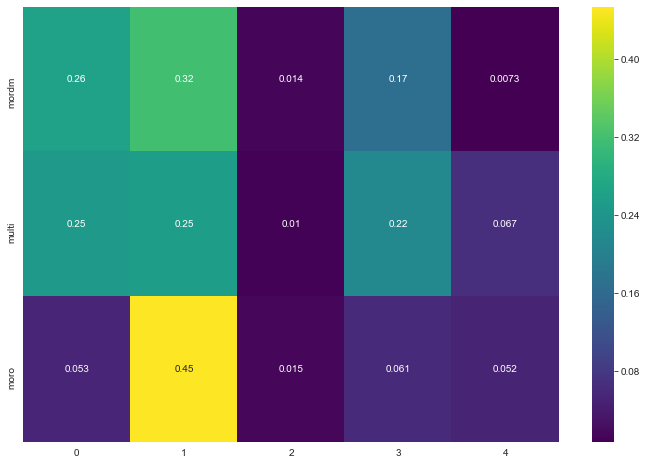

In [118]:
sns.heatmap(hvs, annot=True, cmap='viridis')
plt.show()

In [120]:
counts = counts_in_pareto(all_outcomes, epsilons=[0.1, 0.1, 0.01, 0.01])
counts.to_clipboard()
counts

,0,1,2,3,4
mordm,78,NaN,NaN,14,2
multi,17,15.0,15.0,57,50
moro,1,NaN,1.0,2,1


# re-analyses of all solutions for planned adaptive

In [121]:
pf_results = alldata_by_pf['plannedadaptive']

scenarios = all_scenarios['plannedadaptive']
scenarios = [Scenario(str(i), **entry) for i, entry in enumerate(scenarios)]

In [122]:
from modelData.planned_adaptive import lake_model

model = Model('plannedadaptive', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]
model.constants = [Constant('alpha', 0.41),
                   Constant('reps', 150)]

In [123]:
from ema_workbench import MultiprocessingEvaluator

with MultiprocessingEvaluator(model) as evaluator:
    all_outcomes = []
    
    for method in methods:
        candidate_solutions = pf_results[method]['nondominated'].iloc[:, 0:5]
        policies = get_policies(candidate_solutions, method)
        experiments, outcomes = evaluator.perform_experiments(scenarios=scenarios, policies=policies)
        
        outcomes['policy'] = experiments['policy']
        outcomes['scenario'] = experiments['scenario']
        all_outcomes.append(pd.DataFrame(outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5 scenarios * 48 policies * 1 model(s) = 240 experiments
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 48 cases completed
[MainProcess/INFO] 72 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 144 cases completed
[MainProcess/INFO] 168 cases completed
[MainProcess/INFO] 192 cases completed
[MainProcess/INFO] 216 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 5 scenarios * 77 policies * 1 model(s) = 385 experiments
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 76 cases completed
[MainProcess/INFO] 114 cases completed
[MainProcess/INFO] 152 cases completed
[MainProcess/INFO] 190 cases completed
[MainProcess/INFO] 228 cases completed
[MainProcess/INFO] 266 cases completed
[MainProcess/INFO] 304 cases completed
[MainProcess/INFO] 342 cases completed
[MainProcess/INFO] 

In [124]:
# plot_parcoords(all_outcomes)
# plt.show()

In [125]:
# plot_cdfs(all_outcomes)
# plt.show()

In [127]:
hvs = calculate_hvs(all_outcomes, epsilons=[0.1, 0.1, 0.01, 0.01])
hvs.to_clipboard()
hvs

,0,1,2,3,4
mordm,0.333030,0.021411,0.026279,0.024341,0.033633
multi,0.236223,0.185874,0.220943,0.036030,0.060928
moro,0.249547,0.008428,0.005819,0.010266,0.009694


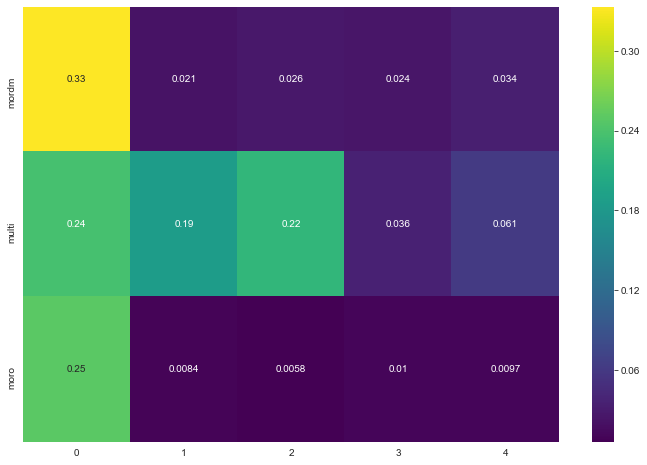

In [128]:
sns.heatmap(hvs, annot=True, cmap='viridis')
plt.show()

In [133]:
counts = counts_in_pareto(all_outcomes, epsilons=[0.1, 0.1, 0.01, 0.01])
counts.to_clipboard()
counts

,0,1,2,3,4
method,,,,,
mordm,30,2,1,2,1
multi,4,12,20,3,5


# re-analyses of all solutions for DPS

In [134]:
pf_results = alldata_by_pf['dps']
scenarios = all_scenarios['dps']
scenarios = [Scenario(str(i), **entry) for i, entry in enumerate(scenarios)]

In [135]:
from modelData.dps import lake_model

model = Model('dps', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]
model.constants = [Constant('alpha', 0.41),
                   Constant('reps', 150)]

In [136]:
from ema_workbench import MultiprocessingEvaluator

with MultiprocessingEvaluator(model) as evaluator:
    all_outcomes = []
    
    for method in methods:
        candidate_solutions = pf_results[method]['nondominated'].iloc[:, 0:5]
        policies = get_policies(candidate_solutions, method)
        experiments, outcomes = evaluator.perform_experiments(scenarios=scenarios, policies=policies)
        
        outcomes['policy'] = experiments['policy']
        outcomes['scenario'] = experiments['scenario']
        all_outcomes.append(pd.DataFrame(outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5 scenarios * 110 policies * 1 model(s) = 550 experiments
[MainProcess/INFO] 55 cases completed
[MainProcess/INFO] 110 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] 220 cases completed
[MainProcess/INFO] 275 cases completed
[MainProcess/INFO] 330 cases completed
[MainProcess/INFO] 385 cases completed
[MainProcess/INFO] 440 cases completed
[MainProcess/INFO] 495 cases completed
[MainProcess/INFO] 550 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 5 scenarios * 94 policies * 1 model(s) = 470 experiments
[MainProcess/INFO] 47 cases completed
[MainProcess/INFO] 94 cases completed
[MainProcess/INFO] 141 cases completed
[MainProcess/INFO] 188 cases completed
[MainProcess/INFO] 235 cases completed
[MainProcess/INFO] 282 cases completed
[MainProcess/INFO] 329 cases completed
[MainProcess/INFO] 376 cases completed
[MainProcess/INFO] 423 cases completed
[MainProcess/IN

In [137]:
# plot_parcoords(all_outcomes)
# plt.show()

In [138]:
# plot_cdfs(all_outcomes)
# plt.show()

In [139]:
hvs = calculate_hvs(all_outcomes, epsilons=[0.1, 0.1, 0.01, 0.01])
hvs.to_clipboard()
hvs

,0,1,2,3,4
mordm,0.354946,0.263832,0.054178,0.041478,0.086017
multi,0.300259,0.321058,0.065761,0.053327,0.104011
moro,0.237762,0.286430,0.009062,0.003143,0.025122


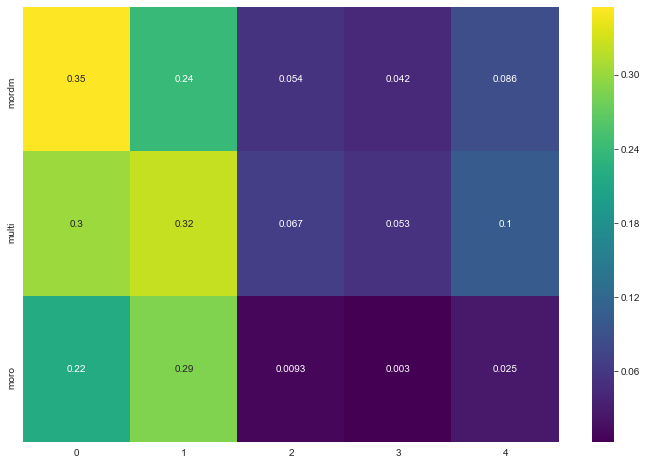

In [81]:
sns.heatmap(hvs, annot=True, cmap='viridis')
plt.show()

In [141]:
counts = counts_in_pareto(all_outcomes, epsilons=[0.1, 0.1, 0.01, 0.01])
counts.to_clipboard()
counts

,0,1,2,3,4
mordm,53,1,NaN,NaN,1
multi,4,27,9.0,8.0,12
